# Analyze gene variants dataset

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
savepath = "dataset/precomputed/variants"

In [2]:
all_class_colors = [(93/255,58/255,155/255,1),(230/255,97/255,0/255,1)]

label_to_name = {
    0:"non-harmful",
    1:"harmful",
}

## Load precomputed graph and lens

In [3]:
labels = np.load(f"{savepath}/labels.npy")
with open(f"{savepath}/train_nodes.txt","r") as f:
    lines = f.readlines()
    train_nodes = [int(i.strip()) for i in lines]
with open(f"{savepath}/test_nodes.txt","r") as f:
    lines = f.readlines()
    test_nodes = [int(i.strip()) for i in lines]
ei,ej,e = [],[],[]
with open(f"{savepath}/edge_list.txt","r") as f:
    lines = f.readlines()
    num_nodes = int(lines[0].strip().split(' ')[0])
    for line in lines[1::]:
        line = line.strip().split(' ')
        ei.append(int(line[0]))
        ej.append(int(line[1]))
        e.append(int(line[2]))
G = sp.csr_matrix((e,(ei,ej)),(num_nodes,num_nodes))
preds = np.load(f"{savepath}/prediction_lens.npy")
extra_lens = np.load(f"{savepath}/extra_lens.npy")
pred_labels = np.argmax(preds,1)

## Compute Reeb graph and estimated errors

In [4]:
from GTDA.GTDA_utils import compute_reeb, NN_model
from GTDA.GTDA import GTDA

nn_model = NN_model()
nn_model.preds = preds
nn_model.labels = labels
nn_model.A = G
nn_model.train_mask = np.zeros(G.shape[0])
nn_model.train_mask[train_nodes] = 1
nn_model.val_mask = np.zeros(G.shape[0])
nn_model.test_mask = np.zeros(G.shape[0])
nn_model.test_mask[test_nodes] = 1
smallest_component = 30
overlap = 0.05
labels_to_eval = list(range(preds.shape[1]))
GTDA_record = compute_reeb(GTDA,nn_model,labels_to_eval,smallest_component,overlap,extra_lens=extra_lens,
    node_size_thd=5,reeb_component_thd=5,nprocs=10,device='cuda',nsteps_mixing=20,nsteps_preprocess=10)

Preprocess lens..
Merge reeb nodes...
Build reeb graph...
Total time for building reeb graph is 5.936134099960327 seconds
Compute mixing rate for each sample


In [5]:
from GTDA.GTDA_utils import save_to_json

save_to_json(GTDA_record, nn_model, savepath, label_to_name)

## Order GTDA components by VCF coordinates

/tmp/ipykernel_1690417/2282689651.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_CCDS = df_CCDS[df_CCDS['gene']=='BRCA1'][df_CCDS['ccds_status']=='Public']


Text(0.5, 1.0, 'order components by VCF coordinates')

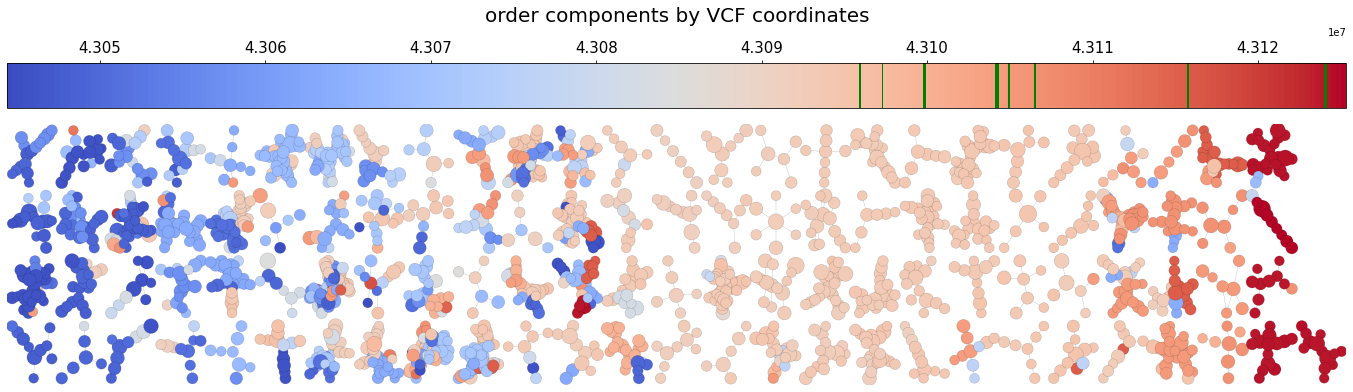

In [5]:
from matplotlib import cm, colors
from GTDA.GTDA_utils import find_components, plot_reeb_component
import networkx as nx
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Rectangle

df_CCDS = pd.read_table("dataset/variants/BRCA1/CCDS.current.txt")
df_CCDS = df_CCDS[df_CCDS['gene']=='BRCA1'][df_CCDS['ccds_status']=='Public']
ccds_id = df_CCDS.iloc[0]['ccds_id']
ccds = df_CCDS.iloc[0]['cds_locations'].replace('[','').replace(']','').split(',')
ccds = [tuple([int(j) for j in i.strip().split('-')]) for i in ccds]
protein_coding = []
for region in ccds:
    for i in range(region[0],region[1]+1):
        protein_coding.append(i)
protein_coding = np.array(protein_coding)
DNA_pos_to_protein_pos = {}
protein_pos_to_DNA_pos = defaultdict(list)
for i,v in enumerate(protein_coding):
    DNA_pos_to_protein_pos[v] = i//3
    protein_pos_to_DNA_pos[i//3].append(v)

coding_1JNX = (1646,1858)
overlapped_DNA_coords = []
for i in range(coding_1JNX[0],coding_1JNX[1]+1):
    overlapped_DNA_coords += protein_pos_to_DNA_pos[i]

gtda = GTDA_record['gtda']
g_reeb = GTDA_record['g_reeb']
reeb_components = find_components(g_reeb,size_thd=0)[1]
model_save_dir = f"dataset/variants/BRCA1"
variant_start_pos = np.load(f"{model_save_dir}/variant_pos.npy")[:,0]
variant_end_pos = np.load(f"{model_save_dir}/variant_pos.npy")[:,1]

max_key = np.max(list(gtda.final_components_filtered.keys()))
node_colors_vcf = np.zeros(max_key+1)
for key,component in gtda.final_components_filtered.items():
    node_colors_vcf[key] = np.median(variant_start_pos[component])
node_colors_vcf = node_colors_vcf[gtda.filtered_nodes]
norm = colors.Normalize(
    vmin=np.min(node_colors_vcf), vmax=np.max(node_colors_vcf), clip=True)
vcf_mapper = cm.ScalarMappable(norm=norm, cmap='coolwarm')
node_colors_vcf = np.array([vcf_mapper.to_rgba(i) for i in node_colors_vcf])

component_vcf_pos = []
for key,reeb_nodes in enumerate(reeb_components):
    component_vcf_pos.append(np.mean(
        [np.median(variant_start_pos[gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]]) for reeb_node in reeb_nodes]))
nrows = 4
component_offset = [0,0]
xcoords = np.zeros(g_reeb.shape[0])
ycoords = np.zeros(g_reeb.shape[0])
g_reeb = g_reeb.tocsr()
direction = 1
scaling = 0.8
for i,component_index in enumerate(np.argsort(component_vcf_pos)):
    component = reeb_components[component_index]
    g_reeb_sub = nx.from_scipy_sparse_matrix(g_reeb[component,:][:,component])
    curr_pos = nx.kamada_kawai_layout(g_reeb_sub,scale=1)
    ymin = np.min([p[1] for p in curr_pos.values()])
    ymax = np.max([p[1] for p in curr_pos.values()])
    xmin = np.min([p[0] for p in curr_pos.values()])
    xmax = np.max([p[0] for p in curr_pos.values()])
    if i%nrows == 0 and i != 0:
        component_offset[0] += 1
        direction *= -1
    else:
        component_offset[1] += direction
    for key,val in curr_pos.items():
        curr_pos[key][0] -= xmin
        curr_pos[key][0] /= (xmax-xmin)
        curr_pos[key][0] *= scaling
        curr_pos[key][0] += scaling/2
        curr_pos[key][1] -= ymin
        curr_pos[key][1] /= (ymax-ymin)
        curr_pos[key][1] *= scaling
        curr_pos[key][1] += scaling/2
        curr_pos[key][0] += component_offset[0]
        curr_pos[key][1] += component_offset[1]
    for j,nid in enumerate(component):
        xcoords[nid] = curr_pos[j][0]
        ycoords[nid] = curr_pos[j][1]

df = pd.DataFrame({'x':xcoords,'y':ycoords,'sizes':40*gtda.node_sizes[gtda.filtered_nodes]**0.5})

fig,ax = plt.subplots(figsize=(nrows*6,6))
fig,ax = plot_reeb_component(g_reeb,df,node_colors_vcf,
    labels_to_eval=labels_to_eval,fig=fig,ax=ax,is_plotting_error=True)

cbar = fig.colorbar(vcf_mapper, ax=ax, orientation='horizontal', location='top', aspect=30)
cbar.ax.tick_params(labelsize=15) 
cbar.ax.yaxis.get_offset_text().set_fontsize(15)
for c in ccds:
    tmp = np.intersect1d(overlapped_DNA_coords,range(c[0],c[1]))
    if len(tmp) > 0:
        cbar.ax.add_patch(Rectangle((np.min(tmp),0),c[1]-np.min(tmp),1,color='green'))
ax.axis('off')
cbar.ax.set_title('order components by VCF coordinates',fontsize=20)

## Find connection with mutation types

100%|██████████| 298/298 [00:00<00:00, 864.05it/s]


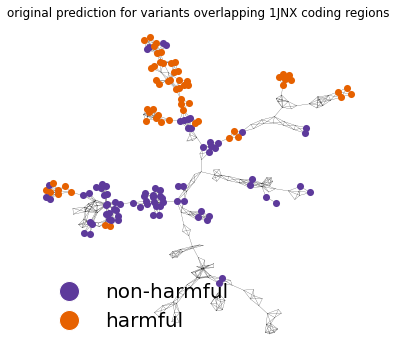

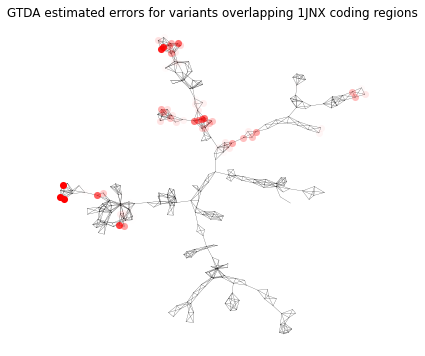

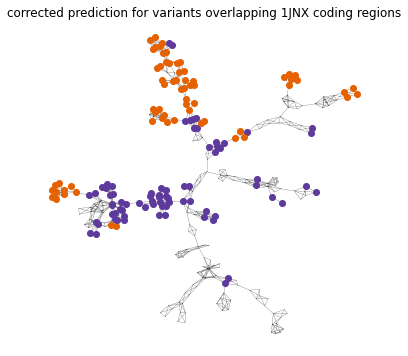

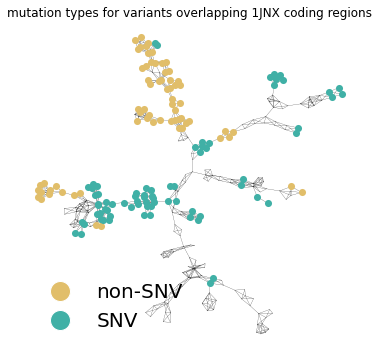

In [6]:
from GTDA.GTDA_utils import plot_subgraph
from matplotlib.lines import Line2D

with open(f"{model_save_dir}/mutation_types.txt","r") as f:
    lines = f.readlines()
    mutation_types = [i.strip() for i in lines]
mutation_type_colors = [(225/255,190/255,106/255,1),(64/255,176/255,166/255,1)]

component_index = 33
nodes = []
for reeb_node in reeb_components[component_index]:
    nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
nodes = np.unique(nodes)
# gtda.A_reeb is the projected Reeb graph
subg = gtda.A_reeb[nodes,:][:,nodes]
tmp_pos = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(subg))
node_colors_pred = []
node_colors_pred_with_correction = []
node_colors_mixing = []
node_colors_mutation_type = []
for i in nodes:
    found = False
    for k in range(variant_start_pos[i],variant_end_pos[i]+1):
        if k in DNA_pos_to_protein_pos and DNA_pos_to_protein_pos[k] in range(coding_1JNX[0],coding_1JNX[1]+1):
            found = True
            break
    if found:
        node_colors_pred.append(all_class_colors[pred_labels[i]])
        # flip prediction if estimated error is larger than prediction probability
        if nn_model.preds[i,pred_labels[i]] < gtda.sample_colors_mixing[i]:
            node_colors_pred_with_correction.append(all_class_colors[1-pred_labels[i]])
        else:
            node_colors_pred_with_correction.append(all_class_colors[pred_labels[i]])
        node_colors_mixing.append((1,0,0,gtda.sample_colors_mixing[i]))
        node_colors_mutation_type.append(mutation_type_colors[int(mutation_types[i]=='single nucleotide variant')])
    else:
        node_colors_pred.append((0,0,0,0))
        node_colors_pred_with_correction.append((0,0,0,0))
        node_colors_mixing.append((0,0,0,0))
        node_colors_mutation_type.append((0,0,0,0))

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_subgraph(node_colors_pred,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('original prediction for variants overlapping 1JNX coding regions')
patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=all_class_colors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=20))
ax.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_subgraph(node_colors_mixing,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('GTDA estimated errors for variants overlapping 1JNX coding regions')

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_subgraph(node_colors_pred_with_correction,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('corrected prediction for variants overlapping 1JNX coding regions')

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_subgraph(node_colors_mutation_type,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('mutation types for variants overlapping 1JNX coding regions')

patches = []
patches.append(
    Line2D(
        [0],[0],marker='o',markerfacecolor=mutation_type_colors[0],
        label="non-SNV",color='w',markersize=20))
patches.append(
    Line2D(
        [0],[0],marker='o',markerfacecolor=mutation_type_colors[1],
        label="SNV",color='w',markersize=20))
ax.legend(handles=patches,fontsize=20,framealpha=0,ncol=1,loc='lower left')

## Find connection with insignificant results

100%|██████████| 346/346 [00:00<00:00, 843.28it/s]


Text(0.5, 1.0, 'insignificant or conflicting gene variants experiments')

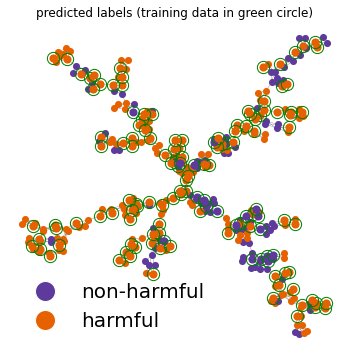

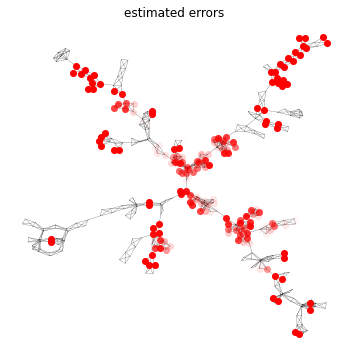

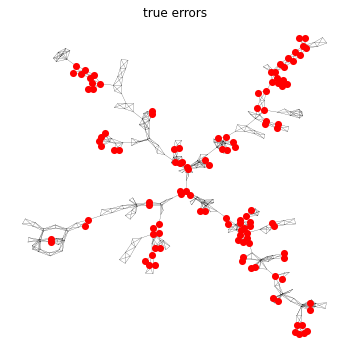

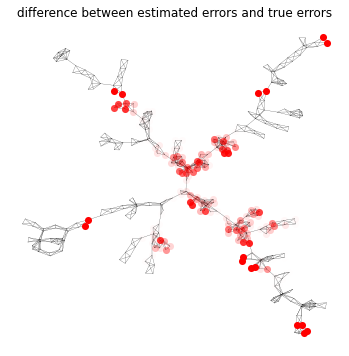

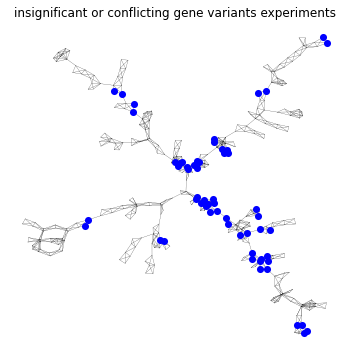

In [8]:
from GTDA.GTDA_utils import plot_subgraph
from matplotlib.lines import Line2D

component_index = 2
nodes = []
for reeb_node in reeb_components[component_index]:
    nodes += gtda.final_components_filtered[gtda.filtered_nodes[reeb_node]]
nodes = np.unique(nodes)
# gtda.A_reeb is the projected Reeb graph
subg = gtda.A_reeb[nodes,:][:,nodes]
tmp_pos = nx.kamada_kawai_layout(nx.from_scipy_sparse_matrix(subg))
node_colors_pred = [all_class_colors[i] for i in pred_labels[nodes]]
node_colors_truth = [all_class_colors[i] for i in labels[nodes]]
tmp_known_nodes = nn_model.train_mask[nodes] + nn_model.val_mask[nodes]

fig,ax = plt.subplots(figsize=(6,6))
fig,ax = plot_subgraph(node_colors_pred,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
for node in np.nonzero(tmp_known_nodes)[0]:
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=node_colors_truth[node],linewidths=1,s=50)
    ax.scatter(
        [tmp_pos[node][0]],[tmp_pos[node][1]],color=(0,0,0,0),linewidths=1,edgecolors='green',s=150)
ax.set_title('predicted labels (training data in green circle)')
patches = []
for label_to_eval in labels_to_eval:
    patches.append(
        Line2D(
            [0],[0],marker='o',markerfacecolor=all_class_colors[label_to_eval],
            label=f"{label_to_name[label_to_eval]}",color='w',markersize=20))
ax.legend(handles=patches,fontsize=20,framealpha=0,ncol=1)

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,gtda.sample_colors_mixing[i]) for i in nodes]
fig,ax = plot_subgraph(node_colors,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('estimated errors')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,gtda.sample_colors_error[i]) for i in nodes]
fig,ax = plot_subgraph(node_colors,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('true errors')

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(1,0,0,np.abs(gtda.sample_colors_error[i]-gtda.sample_colors_mixing[i])) for i in nodes]
fig,ax = plot_subgraph(node_colors,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('difference between estimated errors and true errors')

with open(f"{model_save_dir}/all_significance.txt","r") as f:
    lines = f.readlines()
    all_significance = [i.strip() for i in lines]

insignificant = [
    'Conflicting interpretations of pathogenicity',
    'Uncertain significance',
    'not provided',
    'no interpretation for the single variant'
]
all_significance = np.array([(i in insignificant) for i in all_significance]).astype(np.int32)

fig,ax = plt.subplots(figsize=(6,6))
node_colors = [(0,0,1,all_significance[i]) for i in nodes]
fig,ax = plot_subgraph(node_colors,tmp_pos,subg,nodesize=50,fig=fig,ax=ax)
ax.set_title('insignificant or conflicting gene variants experiments')

